In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

In [ ]:
# tf.random.set_seed(1234)

In [ ]:
url = 'https://raw.githubusercontent.com/Pollutants/Datasets/main/Jul_2017-Nov-2022_8hrs_PollutionData.csv'
df = pd.read_csv(url, engine='python', parse_dates=['From Date'],dayfirst="True")
df

,From Date,To Date,PM2.5
0,2017-07-01 00:00:00,01-07-2017 08:00,28.30
1,2017-07-01 08:00:00,01-07-2017 16:00,31.23
2,2017-07-01 16:00:00,02-07-2017 00:00,45.17
3,2017-07-02 00:00:00,02-07-2017 08:00,34.57
4,2017-07-02 08:00:00,02-07-2017 16:00,40.26
...,...,...,...
5871,2022-11-09 00:00:00,09-11-2022 08:00,52.03
5872,2022-11-09 08:00:00,09-11-2022 16:00,55.35
5873,2022-11-09 16:00:00,10-11-2022 00:00,60.77
5874,2022-11-10 00:00:00,10-11-2022 08:00,76.84


In [ ]:
df.rename(columns = {'From Date':'Date'}, inplace = True)
df.rename(columns = {'PM2.5':'PM25'}, inplace = True)
df

,Date,To Date,PM25
0,2017-07-01 00:00:00,01-07-2017 08:00,28.30
1,2017-07-01 08:00:00,01-07-2017 16:00,31.23
2,2017-07-01 16:00:00,02-07-2017 00:00,45.17
3,2017-07-02 00:00:00,02-07-2017 08:00,34.57
4,2017-07-02 08:00:00,02-07-2017 16:00,40.26
...,...,...,...
5871,2022-11-09 00:00:00,09-11-2022 08:00,52.03
5872,2022-11-09 08:00:00,09-11-2022 16:00,55.35
5873,2022-11-09 16:00:00,10-11-2022 00:00,60.77
5874,2022-11-10 00:00:00,10-11-2022 08:00,76.84


In [ ]:
del df["To Date"]

In [ ]:
import datetime

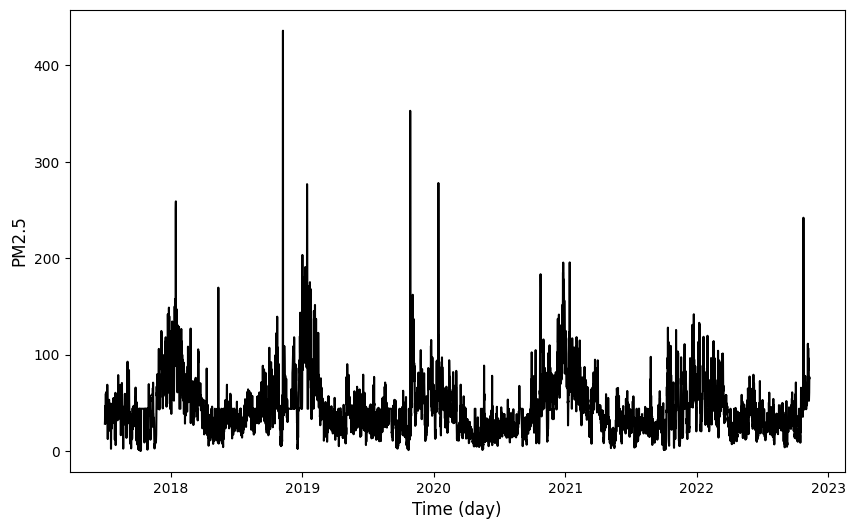

In [ ]:
# Define a function to draw time_series plot
def timeseries (x_axis, y_axis, x_label):
    plt.figure(figsize = (10, 6))
    plt.plot(x_axis, y_axis, color ="black")
    plt.xlabel(x_label, {"fontsize": 12})
    plt.ylabel("PM2.5", {"fontsize": 12})
dataset = df.copy()
timeseries(df.Date, dataset["PM25"], "Time (day)")

<Axes: xlabel='PM25', ylabel='Density'>

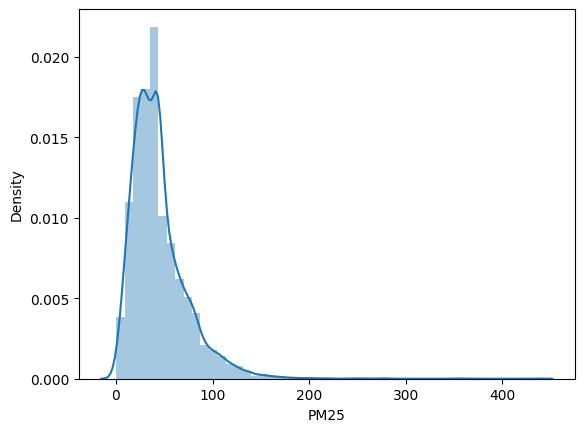

In [ ]:
sns.distplot(df['PM25'])

<Axes: >

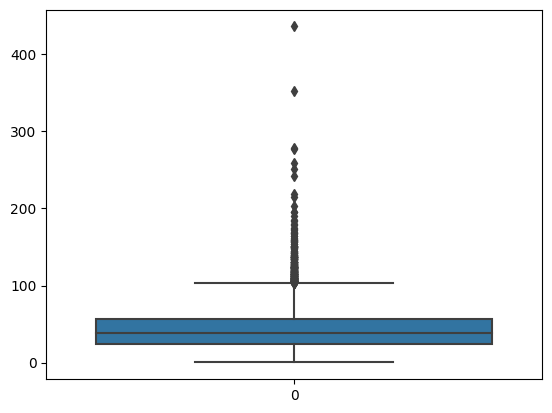

In [ ]:
sns.boxplot(df['PM25'])

In [ ]:
upper_limit = df['PM25'].quantile(0.95)
lower_limit = df['PM25'].quantile(0.01)

In [ ]:
new_df = df[(df['PM25'] <= upper_limit) & (df['PM25'] >= lower_limit)]
new_df

,Date,PM25
0,2017-07-01 00:00:00,28.30
1,2017-07-01 08:00:00,31.23
2,2017-07-01 16:00:00,45.17
3,2017-07-02 00:00:00,34.57
4,2017-07-02 08:00:00,40.26
...,...,...
5871,2022-11-09 00:00:00,52.03
5872,2022-11-09 08:00:00,55.35
5873,2022-11-09 16:00:00,60.77
5874,2022-11-10 00:00:00,76.84


<Axes: >

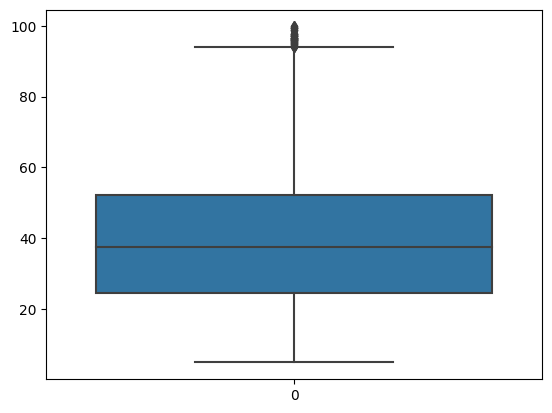

In [ ]:
df = new_df
sns.boxplot(df['PM25'])

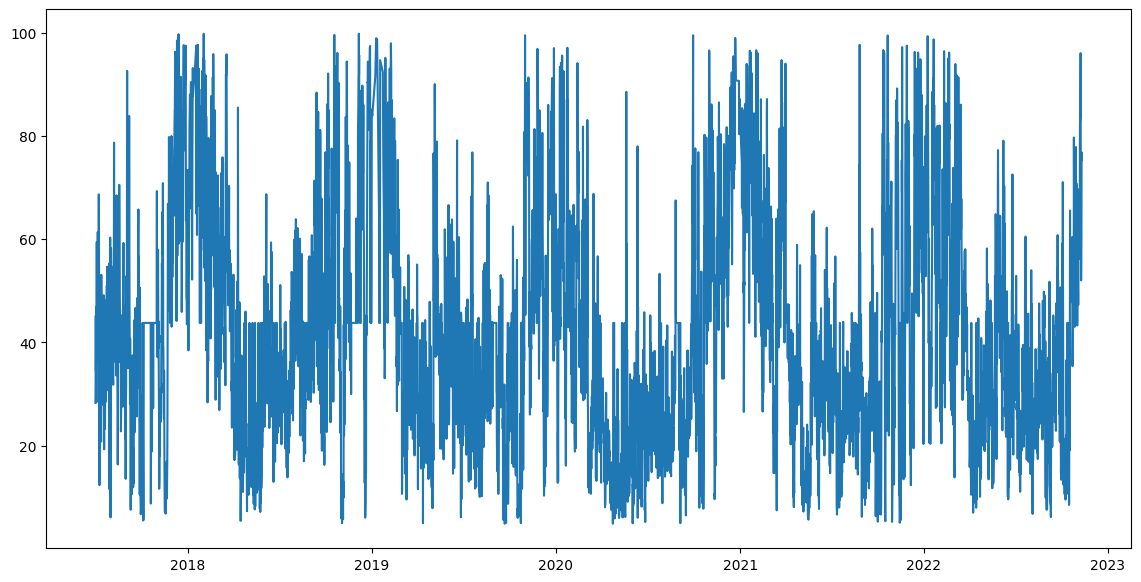

In [ ]:
x = df["Date"]
y = df["PM25"]
plt.figure(figsize=(14,7))
plt.plot(x, y)

In [ ]:
pip install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install --upgrade --no-deps statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

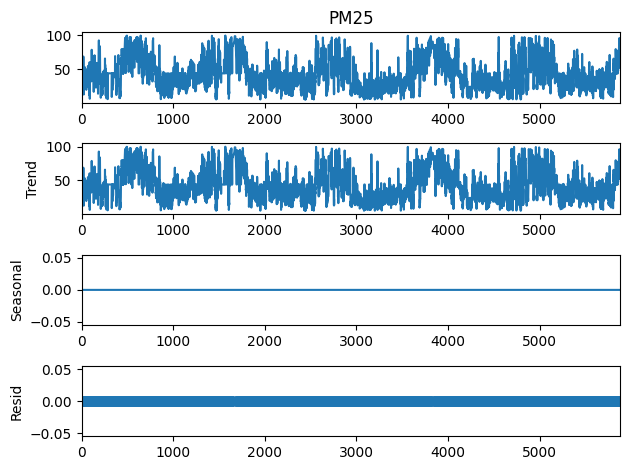

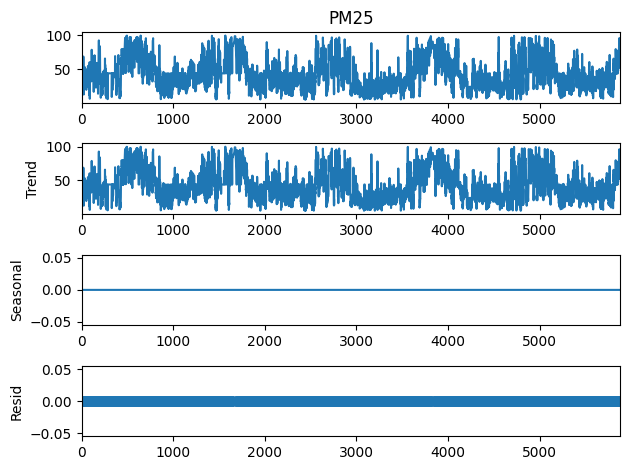

In [ ]:
results=seasonal_decompose(df['PM25'],period=1)
results.plot()

In [ ]:
# Check for missing values
print("Total num of missing values:")
print(df.PM25.isnull().sum())
print("")
# Locate the missing value
df_missing_date = df.loc[df.PM25.isnull() == True]
print("The date of missing value:")
print(df_missing_date.loc[:,["Date"]])
# Replcase missing value with interpolation
df.PM25.interpolate(inplace = True)
# Keep PM25 and drop Date
df = df.drop('Date', axis = 1)

Total num of missing values:
0

The date of missing value:
Empty DataFrame
Columns: [Date]
Index: []


In [ ]:
# Split train data and test data
train_size = 5300

train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

In [ ]:
df

,PM25
0,28.30
1,31.23
2,45.17
3,34.57
4,40.26
...,...
5871,52.03
5872,55.35
5873,60.77
5874,76.84


In [ ]:
scaler = MinMaxScaler().fit(train_data)
train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

In [ ]:
# Create input dataset
def create_dataset (X, look_back = 1):
    Xs, ys = [], []

    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])

    return np.array(Xs), np.array(ys)
LOOK_BACK = 30
X_train, y_train = create_dataset(train_scaled,LOOK_BACK)
X_test, y_test = create_dataset(test_scaled,LOOK_BACK)
# Print data shape
print("X_train.shape: ", X_train.shape)
print("y_train.shape: ", y_train.shape)
print("X_test.shape: ", X_test.shape)
print("y_test.shape: ", y_test.shape)

X_train.shape:  (5270, 30, 1)
y_train.shape:  (5270, 1)
X_test.shape:  (194, 30, 1)
y_test.shape:  (194, 1)


In [ ]:
# Create BiLSTM model
def create_bilstm(units):
    model = Sequential()
    # Input layer
    model.add(Bidirectional(LSTM(units = units, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
    # Hidden layer
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model
model_bilstm = create_bilstm(64)
# Create GRU model
def create_gru(units):
    model = Sequential()
    # Input layer
    model.add(GRU (units = units, return_sequences = True, input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.1))
    # Hidden layer
    model.add(GRU(units = units))
    model.add(Dropout(0.1))
    model.add(Dense(units = 1))
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model
model_gru = create_gru(64)

In [ ]:
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',patience = 10)
    history = model.fit(X_train, y_train, epochs = 50,  validation_split = 0.2,batch_size = 16, shuffle = False, callbacks = [early_stop])
    return history
history_gru = fit_model(model_gru)
history_bilstm = fit_model(model_bilstm)

Epoch 1/50
264/264 [==============================] - 32s 96ms/step - loss: 0.0205 - val_loss: 0.0205
Epoch 2/50
264/264 [==============================] - 11s 42ms/step - loss: 0.0170 - val_loss: 0.0197
Epoch 3/50
264/264 [==============================] - 11s 42ms/step - loss: 0.0168 - val_loss: 0.0201
Epoch 4/50
264/264 [==============================] - 13s 48ms/step - loss: 0.0170 - val_loss: 0.0200
Epoch 5/50
264/264 [==============================] - 11s 41ms/step - loss: 0.0172 - val_loss: 0.0208
Epoch 6/50
264/264 [==============================] - 10s 39ms/step - loss: 0.0168 - val_loss: 0.0204
Epoch 7/50
264/264 [==============================] - 11s 43ms/step - loss: 0.0168 - val_loss: 0.0196
Epoch 8/50
264/264 [==============================] - 11s 42ms/step - loss: 0.0167 - val_loss: 0.0202
Epoch 9/50
264/264 [==============================] - 11s 42ms/step - loss: 0.0167 - val_loss: 0.0204
Epoch 10/50
264/264 [==============================] - 13s 48ms/step - loss: 0.016

In [ ]:
y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

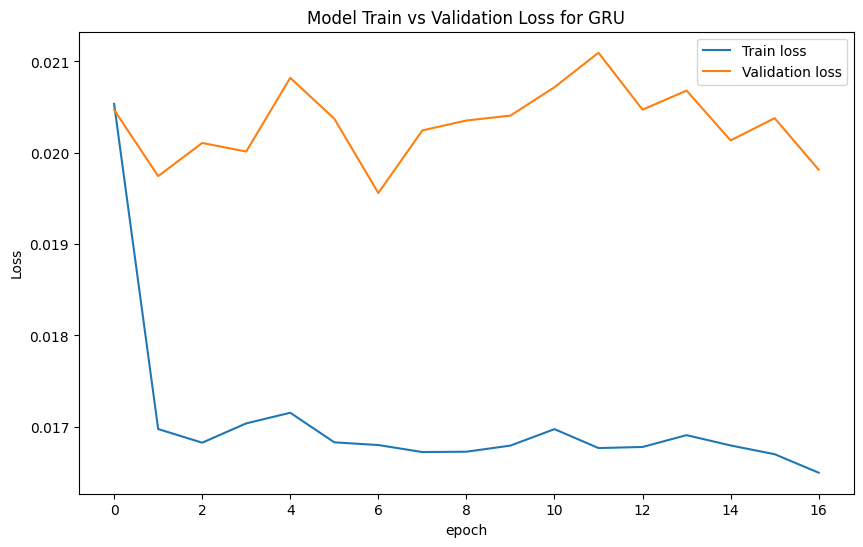

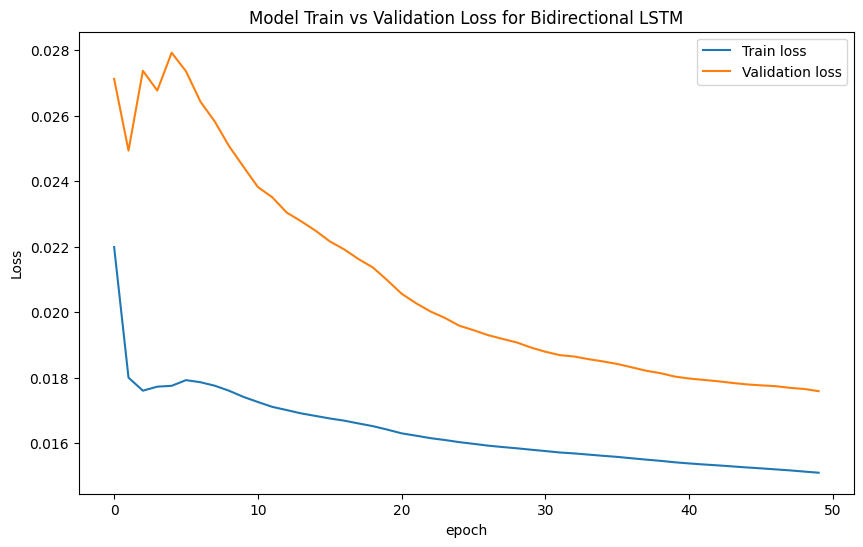

In [ ]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

plot_loss (history_gru, 'GRU')
plot_loss (history_bilstm, 'Bidirectional LSTM')

7/7 [==============================] - 2s 18ms/step


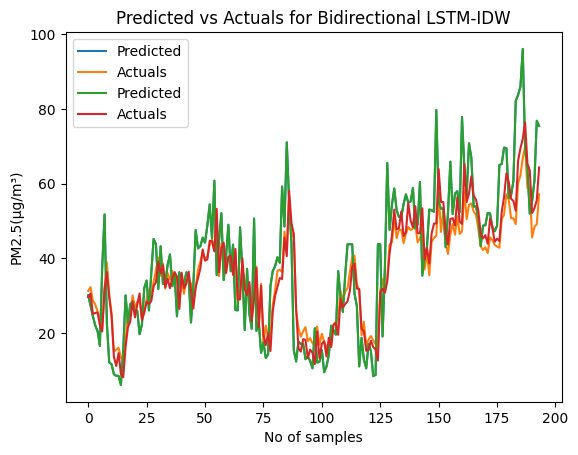

In [ ]:
# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler.inverse_transform(prediction)
    return prediction
prediction_gru = prediction(model_gru)
prediction_bilstm = prediction(model_bilstm)
# Plot test data vs prediction
def plot_future(prediction, model_name, y_test):

    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), label='Predicted')
    plt.plot(np.arange(range_future), np.array(prediction),label='Actuals')
    plt.title('Predicted vs Actuals for '+ model_name+'-IDW')
    plt.legend(loc='upper left')
    plt.xlabel('No of samples')
    plt.ylabel('PM2.5(µg/m³)')

plot_future(prediction_gru, 'GRU', y_test)
plot_future(prediction_bilstm, 'Bidirectional LSTM', y_test)

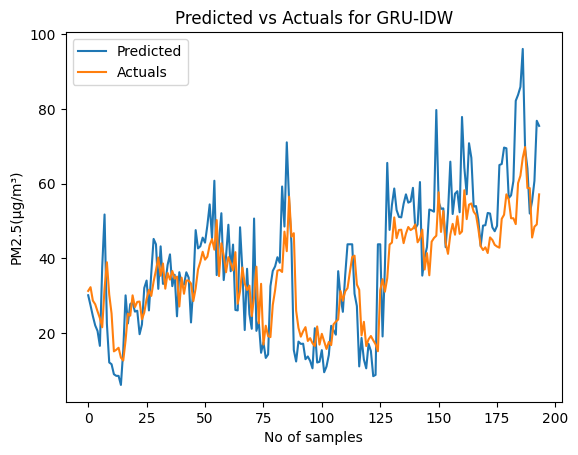

In [ ]:
plot_future(prediction_gru, 'GRU', y_test)

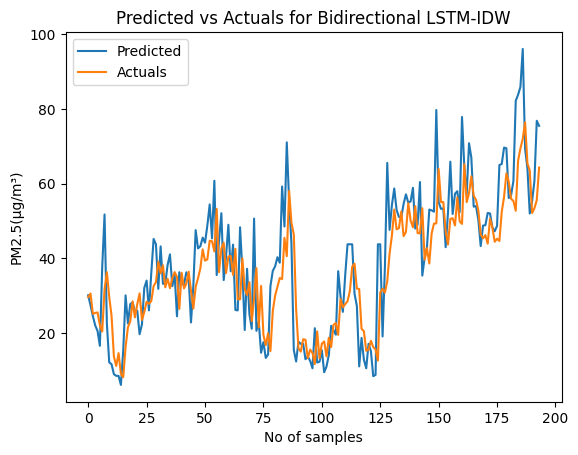

In [ ]:
plot_future(prediction_bilstm, 'Bidirectional LSTM', y_test)

In [ ]:
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print("")
evaluate_prediction(prediction_gru, y_test, 'GRU')
evaluate_prediction(prediction_bilstm, y_test, 'Bidirectiona LSTM')

GRU:
Mean Absolute Error: 8.4893
Root Mean Square Error: 11.1475

Bidirectiona LSTM:
Mean Absolute Error: 7.8565
Root Mean Square Error: 10.5539

